- model : mobilenet_v3_large
- trans : transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
- optim : Adam(torchvision.models.mobilenet_v3_large(input_size = (512,512,3), pooling = 'avg', pretrained = True, weights = 'imagenet').classifier[3].parameters(), lr=0.001)
- lr_scheduler : StepLR(optim, step_size=7, gamma=0.1)

In [1]:
from glob import glob
import pandas as pd
from PIL import Image
import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
import joblib
import time, copy

# Model
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchsummary import summary

# 성능 평가
from sklearn.metrics import f1_score

# 시각화
import matplotlib.pyplot as plt

In [7]:
trans = transforms.Compose([transforms.ToTensor(),
                            transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

In [8]:
train_set = torchvision.datasets.ImageFolder(root = './Train_faabad06fe/Train',
                                             transform = trans)
val_set = torchvision.datasets.ImageFolder(root = './Validation_9857834a3b',
                                           transform = trans)

In [9]:
print(train_set.classes)
print(val_set.classes)

['ILD', 'Lung_Cancer', 'Normal', 'pneumonia', 'pneumothorax']
['ILD', 'Lung_Cancer', 'Normal', 'pneumonia', 'pneumothorax']


In [10]:
image_set = {'train' : train_set, 'val' : val_set}
image_loaders = {x: DataLoader(image_set[x], batch_size=32, shuffle=True, num_workers=0)
                 for x in ['train', 'val']}
dataset_sizes = {x: len(image_set[x]) for x in ['train', 'val']}
class_names = image_set['train'].classes

In [11]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

In [12]:
device

device(type='cuda', index=0)

In [14]:
# 성능 시각화를 위한 losses, flscores 변수 선언.
losses = {'train':[], 'val':[]}
flscores = {'train':[], 'val':[]}

In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1score = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # 각 에폭(epoch)마다 train과 val 단계 진행.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정.
            else:
                model.eval()   # 모델을 평가 모드로 설정.

            running_loss = 0.0
            running_f1score = []

            # 데이터를 반복.
            for inputs, labels in image_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정.
                optimizer.zero_grad()
                
                # 학습.
                if phase == 'train':
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, dim=1)
                        #_, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        f1score = f1_score(labels.data.cpu(), preds.data.cpu(), average = 'macro')

                        # 역전파 + 최적화 진행.
                        loss.requires_grad_(True)
                        loss.backward()
                        optimizer.step()
                
                # 평가.
                if phase == 'val':
                    with torch.no_grad():
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, dim=1)
                        #_, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        f1score = f1_score(labels.data.cpu(), preds.data.cpu(), average = 'macro')
                        
                # 통계.
                running_loss += loss.item() * inputs.size(0)
                running_f1score.append(f1score)
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_f1score = sum(running_f1score) / len(running_f1score)
            
            losses[phase].append(epoch_loss)
            flscores[phase].append(epoch_f1score)
            
            print(f'{phase} Loss: {epoch_loss:.4f} F1-Score: {epoch_f1score:.4f}')

            # 모델 deep copy.
            if phase == 'val' and epoch_f1score > best_f1score:
                best_f1score = epoch_f1score
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val F1-Score: {best_f1score:4f}')

    # 가장 나은 모델 가중치를 불러옴.
    model.load_state_dict(best_model_wts)
    return model

In [16]:
model_conv = torchvision.models.mobilenet_v3_large(input_size = (512,512,3), pooling = 'avg',
                                                   pretrained = True, weights = 'imagenet')

# 새로 생성된 모듈의 매개변수는 기본값이 requires_grad=True
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.classifier[3].in_features
model_conv.classifier[3] = nn.Linear(num_ftrs, 5)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.Adam(model_conv.classifier[3].parameters(), lr=0.001)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [17]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=15)

Epoch 0/14
----------
train Loss: 0.4825 Acc: 0.8405 F1-Score: 0.7356
val Loss: 0.6556 Acc: 0.7550 F1-Score: 0.5638

Epoch 1/14
----------
train Loss: 0.2571 Acc: 0.9164 F1-Score: 0.8530
val Loss: 0.4515 Acc: 0.8150 F1-Score: 0.6638

Epoch 2/14
----------
train Loss: 0.2072 Acc: 0.9324 F1-Score: 0.8792
val Loss: 0.1992 Acc: 0.9250 F1-Score: 0.8750

Epoch 3/14
----------
train Loss: 0.1864 Acc: 0.9374 F1-Score: 0.8902
val Loss: 0.1581 Acc: 0.9520 F1-Score: 0.9084

Epoch 4/14
----------
train Loss: 0.1692 Acc: 0.9430 F1-Score: 0.8984
val Loss: 0.1408 Acc: 0.9540 F1-Score: 0.9146

Epoch 5/14
----------
train Loss: 0.1546 Acc: 0.9508 F1-Score: 0.9125
val Loss: 0.1334 Acc: 0.9590 F1-Score: 0.9262

Epoch 6/14
----------
train Loss: 0.1497 Acc: 0.9500 F1-Score: 0.9115
val Loss: 0.1270 Acc: 0.9580 F1-Score: 0.9191

Epoch 7/14
----------
train Loss: 0.1373 Acc: 0.9581 F1-Score: 0.9245
val Loss: 0.1241 Acc: 0.9620 F1-Score: 0.9370

Epoch 8/14
----------
train Loss: 0.1388 Acc: 0.9538 F1-Score: 0

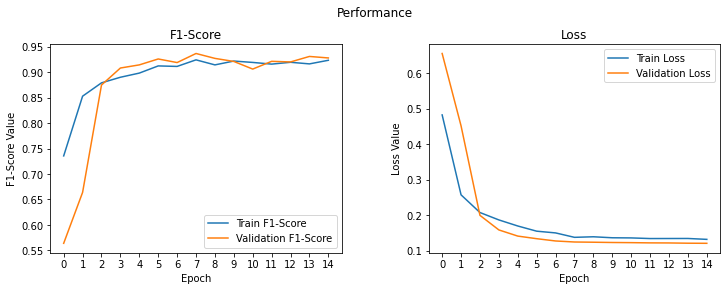

In [18]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = 15 #에폭사이즈
ax1.plot(range(epochs), flscores['train'], label='Train F1-Score')
ax1.plot(range(epochs), flscores['val'], label='Validation F1-Score')
ax1.set_xticks(np.arange(0, epochs))
ax1.set_ylabel('F1-Score Value')
ax1.set_xlabel('Epoch')
ax1.set_title('F1-Score')
l1 = ax1.legend(loc="best")

ax2.plot(range(epochs), losses['train'], label='Train Loss')
ax2.plot(range(epochs), losses['val'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

f.savefig('MoBileNetV3ADAM', dpi = 300)

In [19]:
# 모델저장
torch.save(model_conv, 'MobileNetADam937.pt')